## Calculating the parameters 

In [1]:
import scqubits as scq
import numpy as np
from scipy.optimize import minimize

# Define the target frequencies in GHz
target_f_01 = 0.17  # GHz (170.5 MHz)
target_f_12 = 3.51  # GHz (3510.6 MHz)

# Function to calculate the transition frequencies for Fluxonium
def Fluxonium(EC, EJ, EL):
    fluxonium = scq.Fluxonium(
        EJ=EJ,
        EC=EC,
        EL=EL,
        cutoff=110,  # Cutoff level
        flux=0.5     # Flux bias
    )
    # Get the eigenvalues and calculate the transition frequencies in GHz
    f_01 = fluxonium.eigenvals()[1] - fluxonium.eigenvals()[0]  # 0-1 frequency in GHz
    f_12 = fluxonium.eigenvals()[2] - fluxonium.eigenvals()[1]  # 1-2 frequency in GHz
    
    return f_01, f_12

# Objective function to minimize the difference between calculated and target frequencies
def objective_function(params):
    EC, EJ, EL = params
    calc_frequencies = Fluxonium(EC, EJ, EL)
    target_frequencies = np.array([target_f_01, target_f_12])
    return np.sum((calc_frequencies - target_frequencies)**2)  # Minimize the squared error

# Initial guess for EJ, EC, and EL (in GHz for EJ, EC, and EL)
initial_guess = [0.92, 3.73, 0.36]  # Example initial values in GHz

# Optimize the parameters using minimize
result = minimize(objective_function, initial_guess, bounds=[(0, None), (0, None), (0, None)])

# Output the optimized parameters
optimized_params = result.x
print(f"Optimized EJ = {optimized_params[1]:.2e} GHz")
print(f"Optimized EC = {optimized_params[0]:.2e} GHz")
print(f"Optimized EL = {optimized_params[2]:.2e} GHz")

Fluxonium(optimized_params[0], optimized_params[1], optimized_params[2])



Optimized EJ = 3.72e+00 GHz
Optimized EC = 9.14e-01 GHz
Optimized EL = 3.75e-01 GHz


(np.float64(0.1699997863766558), np.float64(3.5100005425883913))

In [2]:
import scqubits as scq
import numpy as np
from scipy.optimize import minimize

# Define the target frequencies in GHz for Transmon
target_f_01 = 3.8022  # GHz (3802.2 MHz)
target_f_12 = 3.5816  # GHz (3581.6 MHz)

# Function to calculate the transition frequencies for Transmon
def Transmon(EC, EJ):
    transmon = scq.Transmon(
        EJ=EJ,
        EC=EC,
        ng=0,       # No offset charge
        ncut=110,   # Cutoff level
        truncated_dim=20  # Truncation dimension
    )
    # Get the eigenvalues and calculate the transition frequencies in GHz
    f_01 = transmon.eigenvals()[1] - transmon.eigenvals()[0]  # 0-1 frequency in GHz
    f_12 = transmon.eigenvals()[2] - transmon.eigenvals()[1]  # 1-2 frequency in GHz
    
    return f_01, f_12

# Objective function to minimize the difference between calculated and target frequencies
def objective_function(params):
    EC, EJ = params
    calc_frequencies = Transmon(EC, EJ)
    target_frequencies = np.array([target_f_01, target_f_12])
    return np.sum((calc_frequencies - target_frequencies)**2)  # Minimize the squared error

# Initial guess for EJ, EC (in GHz for EJ, EC)
initial_guess = [0.3, 5]  # Example initial values in GHz

# Optimize the parameters using minimize
result = minimize(objective_function, initial_guess, bounds=[(0, None), (0, None)])

# Output the optimized parameters
optimized_params = result.x
print(f"Optimized EJ = {optimized_params[1]:.3e} GHz")
print(f"Optimized EC = {optimized_params[0]:.3e} GHz")

Transmon(optimized_params[0], optimized_params[1])


Optimized EJ = 1.038e+01 GHz
Optimized EC = 1.932e-01 GHz


(np.float64(3.80219943598758), np.float64(3.581600549376397))

## Defining the static hamiltonian

In [4]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)

# Choose the set you want, e.g., "UMA5_design"
# set_name = "CR_set3_high_Jc"
# set_name = "UMA5_design"
# set_name = "FTF_FUN10_Type_3"
# set_name = "FTF_FUN10_Type_1"
set_name = "FUN5_Left"

flux_params = params[set_name]["fluxonium"]
trans_params = params[set_name]["transmon"]
Jc = params[set_name]["Jc"]

EC_flux = flux_params["EC"]
EJ_flux = flux_params["EJ"]
EL_flux = flux_params["EL"]
EC_trans = trans_params["EC"]
EJ_trans = trans_params["EJ"]

qbta = scq.Fluxonium(
    EC=EC_flux, EJ=EJ_flux, EL=EL_flux, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=EJ_trans, EC=EC_trans, ng=0, ncut=110, truncated_dim=20
)


hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=Jc, op1=qbta.n_operator, op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()

# --- Truncate operators ---
total_truncation = 40
def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])

n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian_trunc = truncate(
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
    total_truncation
)



evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28


# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0), (1,2),(2,1), (2,2)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w


Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz

e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_11-e_10

#drive amplitude
SD = 0
A=40



def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)


def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_11 = get_idx((1,1))
idx_10 = get_idx((1,0))
idx_01 = get_idx((0,1))
idx_00 = get_idx((0,0))
# eta = np.real(-n_a[idx_00, idx_01]/n_b[idx_00, idx_01])

# print('eta = ', eta)
print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)


print('n_A_00_01 = ', abs(n_a[idx_00, idx_01]))
print('n_A_10_11 = ', abs(n_a[idx_10, idx_11]))


tlist = np.linspace(0, 400, 400)
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a+ eta*SD *n_b), cosine_drive],  
]

EFT  = .011/95.5
EF   = .12/65
ET   = .163 / 95.5
nF = abs(n_a[idx_00, idx_01])
nT = abs(n_b[idx_00, idx_01])

def eta_p(EF, EFT, ET, nF, nT):
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta_calculated = eta_p(EF, EFT, ET, nF, nT)

H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a * EF+ 0* EFT *n_b), cosine_drive],  
]



H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a * EF+ EFT *n_b + eta_calculated * ET * n_b), cosine_drive],  
]

result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




# plt.figure()
# for idx, res in zip(idxs[:10], result.expect[:6]):
#     plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

# plt.legend()
# plt.ylabel("population")
# plt.xlabel("t (ns)")
# plt.title("Control (Fluxonium) in state |1>")

# plt.figure()
# for idx, res in zip(idxs[:10], result2.expect[:6]):
#     plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

# plt.legend()
# plt.ylabel("population")
# plt.xlabel("t (ns)")
# plt.title("Control (Fluxonium) in state |0>")



fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

# Left subplot (result)
for idx, res in zip(idxs[:10], result.expect[:6]):
    axs[0].plot(tlist, res, label=f"|{index_to_state[idx]}>")
axs[0].legend(fontsize="small", ncol=2)
axs[0].set_ylabel("population")
axs[0].set_xlabel("t (ns)")
axs[0].set_title("Control (Fluxonium) in state |1>")

# Right subplot (result2)
for idx, res in zip(idxs[:10], result2.expect[:6]):
    axs[1].plot(tlist, res, label=f"|{index_to_state[idx]}>")
axs[1].legend(fontsize="small", ncol=2)
axs[1].set_xlabel("t (ns)")
axs[1].set_title("Control (Fluxonium) in state |0>")

plt.tight_layout()
plt.show()

Static_ZZ(MHz)=  0.7512424085329705
dressed_F_01(GHz)=  0.16583515049585182
dressed_F_12(GHz)=  3.532226619111062
dressed_F_03(GHz)=  5.0800126083329
dressed_T_01(GHz)=  3.805268087224104
n_A_00_01 =  0.005097767544970184
n_A_10_11 =  0.025610088180172564


NameError: name 'eta' is not defined

In [228]:
abs(n_b[idx_00, idx_01])

np.float64(1.1095490593626531)

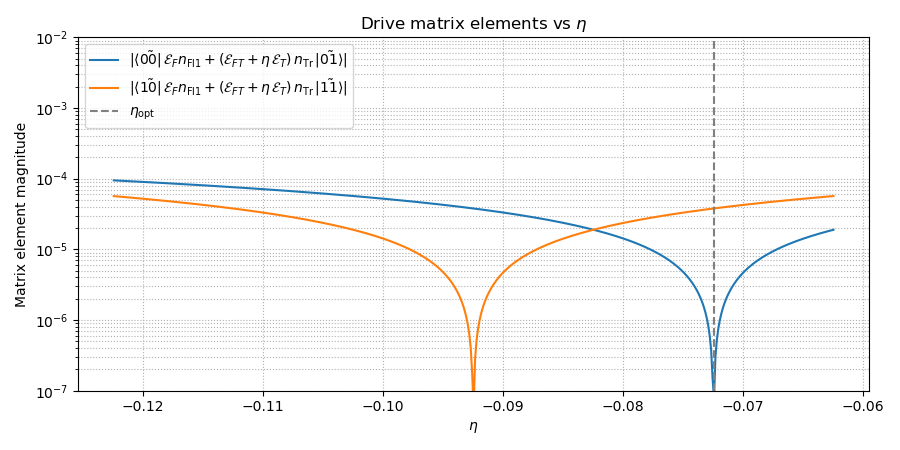

In [223]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(eta_calculated - .05, eta_calculated + .01, 501)



nF_00_01 = abs(n_a[idx_00, idx_01])
nT_00_01 = abs(n_b[idx_00, idx_01])

nF_10_11 = abs(n_a[idx_10, idx_11])
nT_10_11 = abs(n_b[idx_10, idx_11])

O_base_0 = EF * nF_00_01 + EFT * nT_00_01
O_tr_0   = ET * nT_00_01

O_base_1 = EF * nF_10_11 + EFT * nT_10_11
O_tr_1   = ET * nT_10_11

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base_0 + eta_p * O_tr_0) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base_1 + eta_p * O_tr_1) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(eta_calculated, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.ylim(1e-7, 1e-2)

plt.show()


## Checking coherent error

In [7]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Left2"]
# FT_Device = params["FT_NICK"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])


def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

U_ideal = 0 # Identity operator in the computational subspace
U_ideal += dressed_epairs[0, 0][1] * dressed_epairs[0, 0][1].dag()
U_ideal += dressed_epairs[0, 1][1] * dressed_epairs[0, 1][1].dag()
U_ideal += dressed_epairs[1, 1][1] * dressed_epairs[1, 0][1].dag()
U_ideal += dressed_epairs[1, 0][1] * dressed_epairs[1, 1][1].dag()

def U_full2comp(U_f):
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[2*dx+jx,2*kx+lx] = U_f.matrix_element(dressed_epairs[dx,jx][1],dressed_epairs[kx,lx][1])
    return qt.Qobj(U4x4)

idcomp = qt.Qobj(cnot().full())

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

In [330]:
# needed functions
def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def gate(H_tot, args):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    return U_act

def abs_fidelity_CX1(params, t_g, t_r):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))

    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity

def abs_fidelity_CX1_with_crosstalk(params, t_g, t_r, EF, EFT, ET): 
    
    alpha, eta_p, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full +(EFT + ET * eta_p) * n_Tr_full), time_dep]]
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))
    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

# # Example with dummy values
# nF   = abs(n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
# nT   = abs(n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
# EFT  = .011/95.5
# EF   = .12/65
# ET   = .163 / 95.5


# eta_val = eta(EF, EFT, ET, nF, nT)
# print("eta =", eta_val)



In [331]:
nF   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
EFT  = .011/95.5
EF   = .12/65
ET   = .163 / 95.5

eta_p = eta(EF, EFT, ET, nF, nT)
alpha = 30*5
detuning = 0.9999
t_g = 50
t_r = 5
t_list = np.linspace(0, t_g, 1000)

initial_guess = [alpha, eta_p, detuning]


result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
optalpha, opteta_p, optdetuning = result.x

w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

bright = 2/5 * abs(U_act[0,1])

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)


print(f"dark = {dark:.3e}, flip = {flip:.3e}, leak = {leak:.3e}, max_fidelity = {max_fidelity:.6f}")

opt_names = ("optalpha", "opteta_p", "optdetuning")
opt_vals = result.x
print("Optimized parameters:")
for name, val in zip(opt_names, opt_vals):
    print(f"  {name:>12s} = {val:.6g}")

print(f"Optimizer success: {result.success}, nit: {getattr(result, 'nit', 'N/A')}, message: {result.message}")


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16

dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, max_fidelity = 0.998297
Optimized parameters:
      optalpha = 960.43+0j
      opteta_p = -0.0632007+1.82308e-15j
   optdetuning = 1.00009+0j
Optimizer success: True, nit: 135, message: Optimization terminated successfully.


In [304]:
print(f"dark = {dark:.3e}, flip = {flip:.3e}, leak = {leak:.3e}, max_fidelity = {max_fidelity:.6f}, t_g = {t_g:.1f} ns, t_r = {t_r:.1f} ns")

opt_names = ("optalpha", "opteta_p", "optdetuning")
opt_vals = result.x
print("Optimized parameters:")
for name, val in zip(opt_names, opt_vals):
    print(f"  {name:>12s} = {val:.6g}")

print(f"Optimizer success: {result.success}, nit: {getattr(result, 'nit', 'N/A')}, message: {result.message}")

dark = 7.492e-07, flip = 9.369e-04, leak = 1.128e-07, max_fidelity = 0.999063, t_g = 200.0 ns, t_r = 20.0 ns
Optimized parameters:
      optalpha = 189.195+0j
      opteta_p = -0.0615617+1.7758e-15j
   optdetuning = 1.00001+0j
Optimizer success: True, nit: 95, message: Optimization terminated successfully.


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/matplotlib/cbook.py: 1355

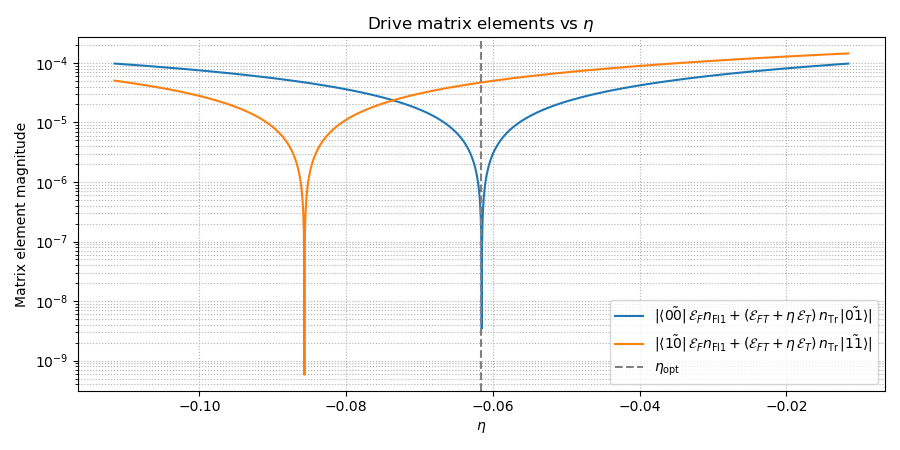

In [301]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(opteta_p - .05, opteta_p + .05, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(opteta_p, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


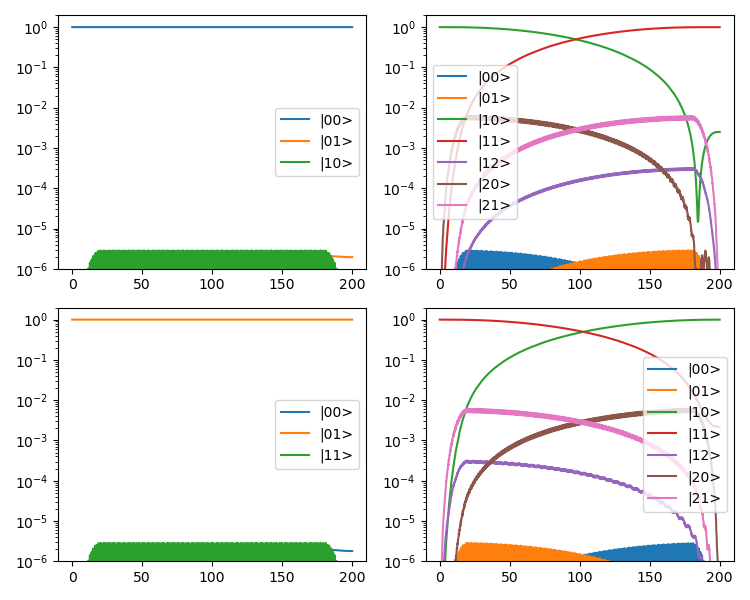

In [374]:

check = False
if check:
    alpha = 7000
    detuning = 0.9999
    t_g = 200
    t_r = 20
    t_list = np.linspace(0, t_g, 1000)
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full + (EFT + ET * eta_val) * n_Tr_full), time_dep]]
else:
    H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(9)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(8):
            idx1 = i // 3
            idx2 = i % 3
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-6 for p in p_list):
                label = "|" + str(j // 3) + str(j % 3) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-6, 2)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

## Incoherent error estimation

In [8]:
# Assuming coherence times and gate time are defined
# Example values (replace with your actual data)
T1_A = 150e-6  # Relaxation time for qubit A (e.g., 50 µs)
T1_B = 33e-6  # Relaxation time for qubit B (e.g., 40 µs)
T2E_A = 85e-6  # Echo dephasing time for qubit A (e.g., 30 µs)
T2E_B = 40e-6  # Echo dephasing time for qubit B (e.g., 25 µs)
t_gate = (200 )* 1e-9  # Gate time (e.g., 100 ns, from your t_g)

# T1_A = 260e-6  # Relaxation time for qubit A (e.g., 50 µs) # params from 24 days stable CNOT gate paper
# T1_B = 160e-6  # Relaxation time for qubit B (e.g., 40 µs)
# T2E_A = 200e-6  # Echo dephasing time for qubit A (e.g., 30 µs)
# T2E_B = 150e-6  # Echo dephasing time for qubit B (e.g., 25 µs)
# t_gate = (50 )* 1e-9  # Gate time (e.g., 100 ns, from your t_g)

# Ebru params
T1_A = 60-6  # Relaxation time for qubit A (e.g., 50 µs) 
T1_B = 33e-6  # Relaxation time for qubit B (e.g., 40 µs)
T2E_A = 24e-6  # Echo dephasing time for qubit A (e.g., 30 µs)
T2E_B = 16.5e-6  # Echo dephasing time for qubit B (e.g., 25 µs)
t_gate = (60 )* 1e-9  # Gate time (e.g., 100 ns, from your t_g)

# Calculate incoherent fidelity error
delta_F_incoherent = (1/5) * (t_gate / T1_A) + (1/5) * (t_gate / T1_B) + (2/5) * (t_gate / T2E_A) + (2/5) * (t_gate / T2E_B)

# Print the result
print(f"delta_F_incoherent = {delta_F_incoherent:.6f}")

max_fidelity_incoherent = 1 - delta_F_incoherent 

print(f"1-coherent_error - incoherent_error = {max_fidelity_incoherent:.6f}")


delta_F_incoherent = 0.002818
1-coherent_error - incoherent_error = 0.997182


## All error togerther sweep gate time


t_r = 5 ns, t_g = 50 ns:
  max_fidelity = 0.998297
  dark = 1.004e-03
  flip = 3.631e-04
  leak = 1.679e-03
  delta_F_incoherent = 0.001105
  max_fidelity_incoherent = 0.997192

t_r = 5 ns, t_g = 75 ns:
  max_fidelity = 0.999633
  dark = 8.046e-05
  flip = 2.170e-04
  leak = 3.496e-04
  delta_F_incoherent = 0.001657
  max_fidelity_incoherent = 0.997975

t_r = 5 ns, t_g = 100 ns:
  max_fidelity = 0.999797
  dark = 1.750e-05
  flip = 1.684e-04
  leak = 8.628e-05
  delta_F_incoherent = 0.002210
  max_fidelity_incoherent = 0.997587

t_r = 5 ns, t_g = 150 ns:
  max_fidelity = 0.999643
  dark = 8.248e-07
  flip = 3.408e-04
  leak = 7.708e-05
  delta_F_incoherent = 0.003315
  max_fidelity_incoherent = 0.996328

t_r = 5 ns, t_g = 200 ns:
  max_fidelity = 0.999458
  dark = 4.063e-07
  flip = 5.349e-04
  leak = 3.147e-05
  delta_F_incoherent = 0.004420
  max_fidelity_incoherent = 0.995039

t_r = 10 ns, t_g = 50 ns:
  max_fidelity = 0.999982
  dark = 4.061e-06
  flip = 1.058e-05
  leak = 1.465e-

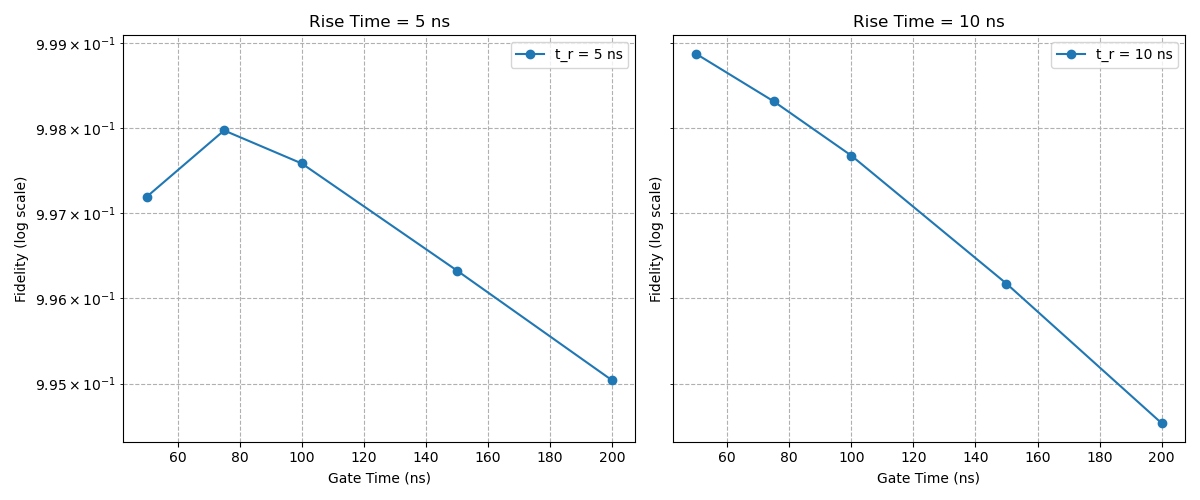


Summary for t_r = 5 ns:
  t_g = 50 ns: max_fidelity = 0.998297, dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, delta_F_incoherent = 0.001105, max_fidelity_incoherent = 0.997192
  t_g = 75 ns: max_fidelity = 0.999633, dark = 8.046e-05, flip = 2.170e-04, leak = 3.496e-04, delta_F_incoherent = 0.001657, max_fidelity_incoherent = 0.997975
  t_g = 100 ns: max_fidelity = 0.999797, dark = 1.750e-05, flip = 1.684e-04, leak = 8.628e-05, delta_F_incoherent = 0.002210, max_fidelity_incoherent = 0.997587
  t_g = 150 ns: max_fidelity = 0.999643, dark = 8.248e-07, flip = 3.408e-04, leak = 7.708e-05, delta_F_incoherent = 0.003315, max_fidelity_incoherent = 0.996328
  t_g = 200 ns: max_fidelity = 0.999458, dark = 4.063e-07, flip = 5.349e-04, leak = 3.147e-05, delta_F_incoherent = 0.004420, max_fidelity_incoherent = 0.995039

Summary for t_r = 10 ns:
  t_g = 50 ns: max_fidelity = 0.999982, dark = 4.061e-06, flip = 1.058e-05, leak = 1.465e-05, delta_F_incoherent = 0.001105, max_fidelity_incohere

In [334]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Define coherence times from your experiment
T1_A = 150e-6  # Relaxation time for qubit A (µs to s)
T1_B = 33e-6   # Relaxation time for qubit B (µs to s)
T2E_A = 85e-6  # Echo dephasing time for qubit A (µs to s)
T2E_B = 40e-6  # Echo dephasing time for qubit B (µs to s)

# Define parameter ranges
t_g_values = [50, 75, 100, 150, 200]  # Gate times in ns
t_r_values = [5, 10]                   # Rise times in ns

# Store results
results = {t_r: {'t_g': [], 'max_fidelity': [], 'dark': [], 'flip': [], 'leak': [], 'delta_F_incoherent': [], 'max_fidelity_incoherent': []} 
           for t_r in t_r_values}

# Optimization and calculations for each t_g and t_r
for t_r in t_r_values:
    for t_g in t_g_values:
        t_list = np.linspace(0, t_g, 1000)
        
        # Calculate eta_p
        nF = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
        nT = n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
        EFT = 0.011 / 95.5
        EF = 0.12 / 65
        ET = 0.163 / 95.5
        eta_p = eta(EF, EFT, ET, nF, nT)
        
        alpha = 30 * 5  # Initial alpha value
        detuning = 0.9999
        
        initial_guess = [alpha, eta_p, detuning]
        
        result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), 
                             method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
        optalpha, opteta_p, optdetuning = result.x
        
        w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0]) * optdetuning
        H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]
        
        args = {'t_g': t_g, 'w_d': w_d, 't_r': t_r}
        
        U_act = np.abs(U_full2comp(gate(H_tot, args)).full())
        
        max_fidelity = -result.fun
        
        a = 1 - U_act[0, 0]
        b = 1 - U_act[1, 1]
        c = 1 - U_act[2, 3]
        d = 1 - U_act[3, 2]
        
        dark = 2 * (a + b) / 5
        flip = 2 * (c + d) / 5
        
        leak = abs(1 - np.trace(np.transpose(U_act) @ U_act) / 4)
        
        # Calculate incoherent fidelity error
        t_gate = t_g * 1e-9  # Convert t_g from ns to s
        delta_F_incoherent = (1/5) * (t_gate / T1_A) + (1/5) * (t_gate / T1_B) + (2/5) * (t_gate / T2E_A) + (2/5) * (t_gate / T2E_B)
        
        # Calculate max fidelity accounting for incoherent errors
        max_fidelity_incoherent = max_fidelity - delta_F_incoherent
        
        # Store results
        results[t_r]['t_g'].append(t_g)
        results[t_r]['max_fidelity'].append(max_fidelity)
        results[t_r]['dark'].append(dark)
        results[t_r]['flip'].append(flip)
        results[t_r]['leak'].append(leak)
        results[t_r]['delta_F_incoherent'].append(delta_F_incoherent)
        results[t_r]['max_fidelity_incoherent'].append(max_fidelity_incoherent)
        
        # Print values after each iteration
        print(f"\nt_r = {t_r} ns, t_g = {t_g} ns:")
        print(f"  max_fidelity = {max_fidelity:.6f}")
        print(f"  dark = {dark:.3e}")
        print(f"  flip = {flip:.3e}")
        print(f"  leak = {leak:.3e}")
        print(f"  delta_F_incoherent = {delta_F_incoherent:.6f}")
        print(f"  max_fidelity_incoherent = {max_fidelity_incoherent:.6f}")

# Plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, t_r in zip([ax1, ax2], t_r_values):
    ax.semilogy(results[t_r]['t_g'], results[t_r]['max_fidelity_incoherent'], 
                label=f't_r = {t_r} ns', marker='o')
    ax.set_xlabel('Gate Time (ns)')
    ax.set_ylabel('Fidelity (log scale)')
    ax.set_title(f'Rise Time = {t_r} ns')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results for all iterations (optional summary)
for t_r in t_r_values:
    print(f"\nSummary for t_r = {t_r} ns:")
    for i, t_g in enumerate(t_g_values):
        print(f"  t_g = {t_g} ns: "
              f"max_fidelity = {results[t_r]['max_fidelity'][i]:.6f}, "
              f"dark = {results[t_r]['dark'][i]:.3e}, "
              f"flip = {results[t_r]['flip'][i]:.3e}, "
              f"leak = {results[t_r]['leak'][i]:.3e}, "
              f"delta_F_incoherent = {results[t_r]['delta_F_incoherent'][i]:.6f}, "
              f"max_fidelity_incoherent = {results[t_r]['max_fidelity_incoherent'][i]:.6f}")

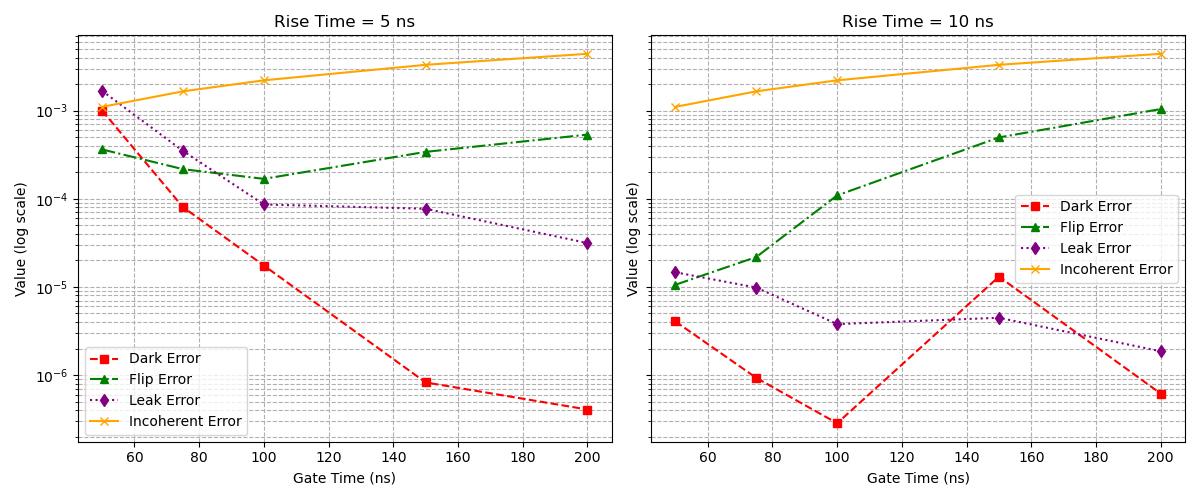


Summary for t_r = 5 ns:
  t_g = 50 ns: max_fidelity = 0.998297, dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, delta_F_incoherent = 0.001105, max_fidelity_incoherent = 0.997192
  t_g = 75 ns: max_fidelity = 0.999633, dark = 8.046e-05, flip = 2.170e-04, leak = 3.496e-04, delta_F_incoherent = 0.001657, max_fidelity_incoherent = 0.997975
  t_g = 100 ns: max_fidelity = 0.999797, dark = 1.750e-05, flip = 1.684e-04, leak = 8.628e-05, delta_F_incoherent = 0.002210, max_fidelity_incoherent = 0.997587
  t_g = 150 ns: max_fidelity = 0.999643, dark = 8.248e-07, flip = 3.408e-04, leak = 7.708e-05, delta_F_incoherent = 0.003315, max_fidelity_incoherent = 0.996328
  t_g = 200 ns: max_fidelity = 0.999458, dark = 4.063e-07, flip = 5.349e-04, leak = 3.147e-05, delta_F_incoherent = 0.004420, max_fidelity_incoherent = 0.995039

Summary for t_r = 10 ns:
  t_g = 50 ns: max_fidelity = 0.999982, dark = 4.061e-06, flip = 1.058e-05, leak = 1.465e-05, delta_F_incoherent = 0.001105, max_fidelity_incohere

In [336]:
# Plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, t_r in zip([ax1, ax2], t_r_values):
    # Plot max_fidelity_incoherent
    # ax.semilogy(results[t_r]['t_g'], results[t_r]['max_fidelity_incoherent'], 
    #             label='Max Fidelity (Incoherent)', marker='o', linestyle='-', color='blue')
    
    # Plot dark error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['dark'], 
                label='Dark Error', marker='s', linestyle='--', color='red')
    
    # Plot flip error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['flip'], 
                label='Flip Error', marker='^', linestyle='-.', color='green')
    
    # Plot leak error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['leak'], 
                label='Leak Error', marker='d', linestyle=':', color='purple')
    
    # Plot incoherent fidelity error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['delta_F_incoherent'], 
                label='Incoherent Error', marker='x', linestyle='-', color='orange')
    
    ax.set_xlabel('Gate Time (ns)')
    ax.set_ylabel('Value (log scale)')
    ax.set_title(f'Rise Time = {t_r} ns')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results for all iterations (optional summary)
for t_r in t_r_values:
    print(f"\nSummary for t_r = {t_r} ns:")
    for i, t_g in enumerate(t_g_values):
        print(f"  t_g = {t_g} ns: "
              f"max_fidelity = {results[t_r]['max_fidelity'][i]:.6f}, "
              f"dark = {results[t_r]['dark'][i]:.3e}, "
              f"flip = {results[t_r]['flip'][i]:.3e}, "
              f"leak = {results[t_r]['leak'][i]:.3e}, "
              f"delta_F_incoherent = {results[t_r]['delta_F_incoherent'][i]:.6f}, "
              f"max_fidelity_incoherent = {results[t_r]['max_fidelity_incoherent'][i]:.6f}")

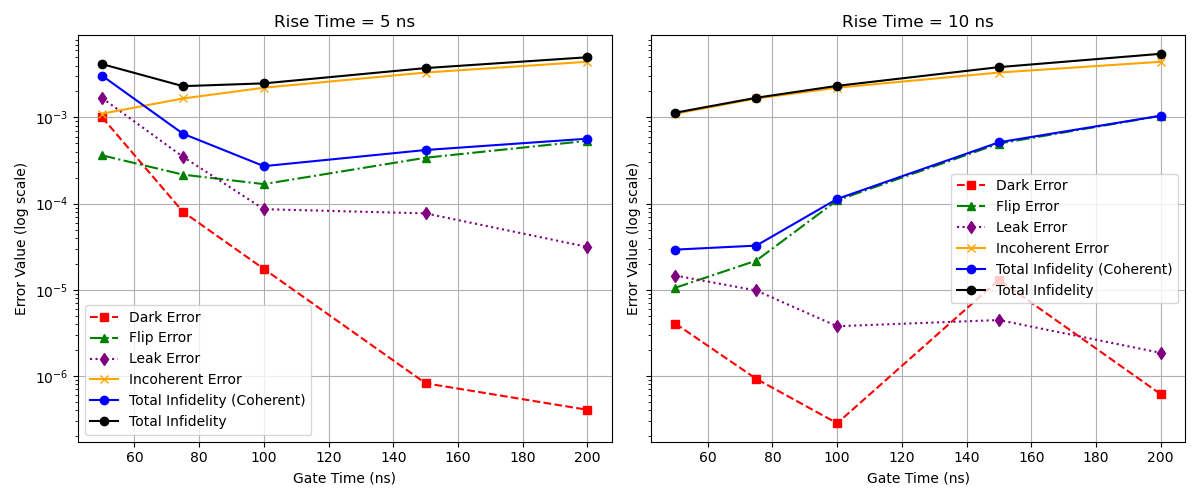


Summary for t_r = 5 ns:
  t_g = 50 ns: dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, delta_F_incoherent = 0.001105, total_infidelity = 0.004151
  t_g = 75 ns: dark = 8.046e-05, flip = 2.170e-04, leak = 3.496e-04, delta_F_incoherent = 0.001657, total_infidelity = 0.002304
  t_g = 100 ns: dark = 1.750e-05, flip = 1.684e-04, leak = 8.628e-05, delta_F_incoherent = 0.002210, total_infidelity = 0.002482
  t_g = 150 ns: dark = 8.248e-07, flip = 3.408e-04, leak = 7.708e-05, delta_F_incoherent = 0.003315, total_infidelity = 0.003734
  t_g = 200 ns: dark = 4.063e-07, flip = 5.349e-04, leak = 3.147e-05, delta_F_incoherent = 0.004420, total_infidelity = 0.004987

Summary for t_r = 10 ns:
  t_g = 50 ns: dark = 4.061e-06, flip = 1.058e-05, leak = 1.465e-05, delta_F_incoherent = 0.001105, total_infidelity = 0.001134
  t_g = 75 ns: dark = 9.290e-07, flip = 2.184e-05, leak = 9.832e-06, delta_F_incoherent = 0.001657, total_infidelity = 0.001690
  t_g = 100 ns: dark = 2.838e-07, flip = 1.093e-04

In [341]:
# Plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, t_r in zip([ax1, ax2], t_r_values):
    # Plot dark error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['dark'], 
                label='Dark Error', marker='s', linestyle='--', color='red')
    
    # Plot flip error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['flip'], 
                label='Flip Error', marker='^', linestyle='-.', color='green')
    
    # Plot leak error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['leak'], 
                label='Leak Error', marker='d', linestyle=':', color='purple')
    
    # Plot incoherent fidelity error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['delta_F_incoherent'], 
                label='Incoherent Error', marker='x', linestyle='-', color='orange')
    
    # Calculate and plot total infidelity
    total_infidelity_coherent = [d + f + l for d, f, l in zip(results[t_r]['dark'], results[t_r]['flip'], 
                                                            results[t_r]['leak'])]
    ax.semilogy(results[t_r]['t_g'], total_infidelity_coherent, 
                label='Total Infidelity (Coherent)', marker='o', linestyle='-', color='blue')

        # Calculate and plot total infidelity
    total_infidelity = [d + f + l + i for d, f, l, i in zip(results[t_r]['dark'], results[t_r]['flip'], 
                                                            results[t_r]['leak'], results[t_r]['delta_F_incoherent'])]
    ax.semilogy(results[t_r]['t_g'], total_infidelity, 
                label='Total Infidelity', marker='o', linestyle='-', color='black')
    
    ax.set_xlabel('Gate Time (ns)')
    ax.set_ylabel('Error Value (log scale)')
    ax.set_title(f'Rise Time = {t_r} ns')
    ax.grid()
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results for all iterations (optional summary)
for t_r in t_r_values:
    print(f"\nSummary for t_r = {t_r} ns:")
    for i, t_g in enumerate(t_g_values):
        total_infidelity = (results[t_r]['dark'][i] + results[t_r]['flip'][i] + 
                           results[t_r]['leak'][i] + results[t_r]['delta_F_incoherent'][i])
        print(f"  t_g = {t_g} ns: "
              f"dark = {results[t_r]['dark'][i]:.3e}, "
              f"flip = {results[t_r]['flip'][i]:.3e}, "
              f"leak = {results[t_r]['leak'][i]:.3e}, "
              f"delta_F_incoherent = {results[t_r]['delta_F_incoherent'][i]:.6f}, "
              f"total_infidelity = {total_infidelity:.6f}")

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16


t_r = 5 ns, t_g = 50 ns:
  max_fidelity = 0.998297
  dark = 1.004e-03
  flip = 3.631e-04
  leak = 1.679e-03
  delta_F_incoherent = 0.001105
  max_fidelity_incoherent = 0.997192
  optalpha = 960.430426+0.000000j

t_r = 5 ns, t_g = 75 ns:
  max_fidelity = 0.999633
  dark = 8.046e-05
  flip = 2.170e-04
  leak = 3.496e-04
  delta_F_incoherent = 0.001657
  max_fidelity_incoherent = 0.997975
  optalpha = 520.466426+0.000000j

t_r = 5 ns, t_g = 100 ns:
  max_fidelity = 0.999797
  dark = 1.750e-05
  flip = 1.684e-04
  leak = 8.628e-05
  delta_F_incoherent = 0.002210
  max_fidelity_incoherent = 0.997587
  optalpha = 367.054257+0.000000j

t_r = 5 ns, t_g = 150 ns:
  max_fidelity = 0.999643
  dark = 8.248e-07
  flip = 3.408e-04
  leak = 7.708e-05
  delta_F_incoherent = 0.003315
  max_fidelity_incoherent = 0.996328
  optalpha = 234.096114+0.000000j

t_r = 5 ns, t_g = 200 ns:
  max_fidelity = 0.999458
  dark = 4.063e-07
  flip = 5.349e-04
  leak = 3.147e-05
  delta_F_incoherent = 0.004420
  max_fi

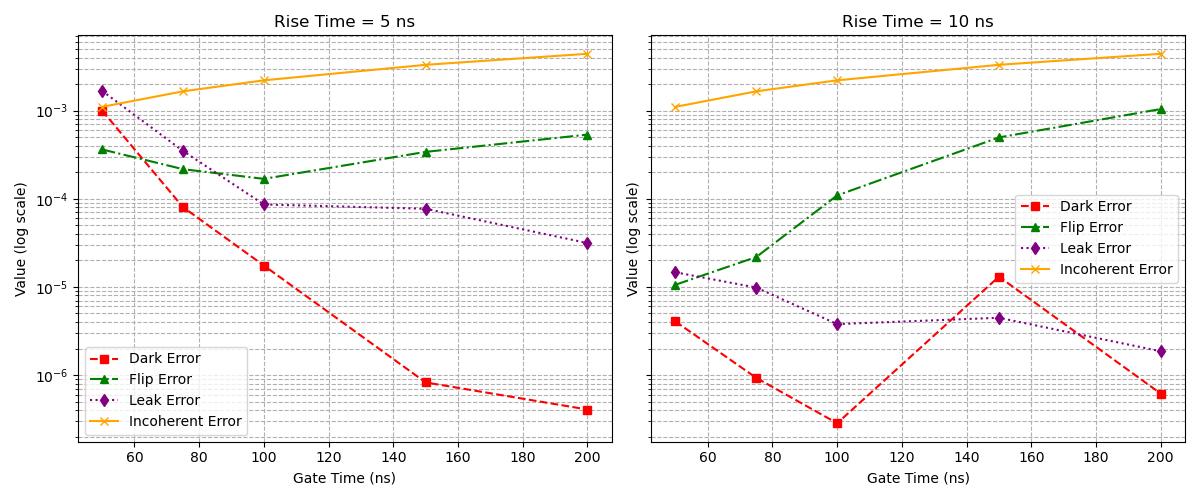


Summary for t_r = 5 ns (First Set):
  t_g = 50 ns: max_fidelity = 0.998297, dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, delta_F_incoherent = 0.001105, max_fidelity_incoherent = 0.997192, optalpha = 960.430426+0.000000j
  t_g = 75 ns: max_fidelity = 0.999633, dark = 8.046e-05, flip = 2.170e-04, leak = 3.496e-04, delta_F_incoherent = 0.001657, max_fidelity_incoherent = 0.997975, optalpha = 520.466426+0.000000j
  t_g = 100 ns: max_fidelity = 0.999797, dark = 1.750e-05, flip = 1.684e-04, leak = 8.628e-05, delta_F_incoherent = 0.002210, max_fidelity_incoherent = 0.997587, optalpha = 367.054257+0.000000j
  t_g = 150 ns: max_fidelity = 0.999643, dark = 8.248e-07, flip = 3.408e-04, leak = 7.708e-05, delta_F_incoherent = 0.003315, max_fidelity_incoherent = 0.996328, optalpha = 234.096114+0.000000j
  t_g = 200 ns: max_fidelity = 0.999458, dark = 4.063e-07, flip = 5.349e-04, leak = 3.147e-05, delta_F_incoherent = 0.004420, max_fidelity_incoherent = 0.995039, optalpha = 172.309685+0.000

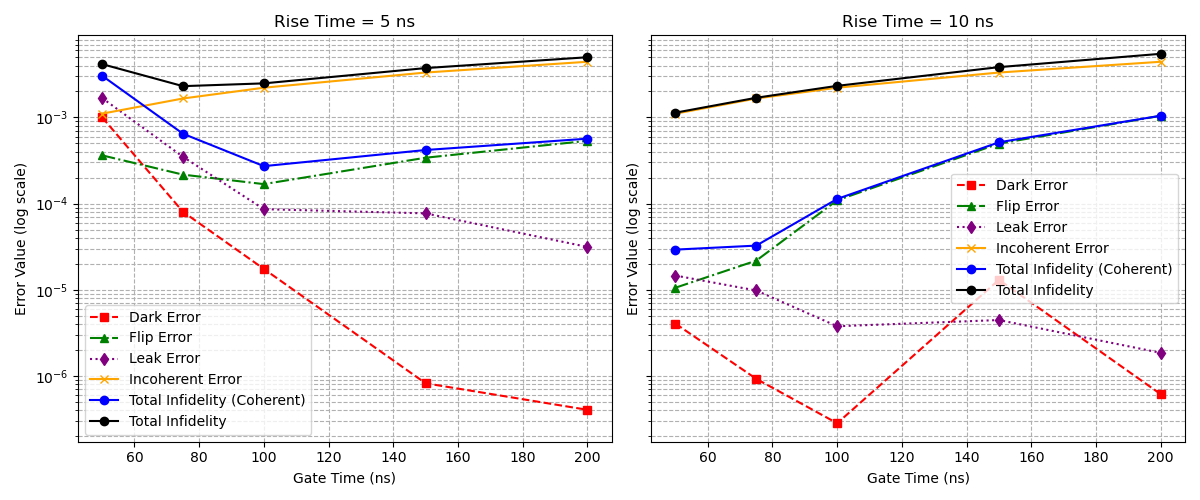


Summary for t_r = 5 ns (Second Set):
  t_g = 50 ns: optalpha = 960.430426+0.000000j, dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, delta_F_incoherent = 0.001105, total_infidelity = 0.004151
  t_g = 75 ns: optalpha = 520.466426+0.000000j, dark = 8.046e-05, flip = 2.170e-04, leak = 3.496e-04, delta_F_incoherent = 0.001657, total_infidelity = 0.002304
  t_g = 100 ns: optalpha = 367.054257+0.000000j, dark = 1.750e-05, flip = 1.684e-04, leak = 8.628e-05, delta_F_incoherent = 0.002210, total_infidelity = 0.002482
  t_g = 150 ns: optalpha = 234.096114+0.000000j, dark = 8.248e-07, flip = 3.408e-04, leak = 7.708e-05, delta_F_incoherent = 0.003315, total_infidelity = 0.003734
  t_g = 200 ns: optalpha = 172.309685+0.000000j, dark = 4.063e-07, flip = 5.349e-04, leak = 3.147e-05, delta_F_incoherent = 0.004420, total_infidelity = 0.004987

Summary for t_r = 10 ns (Second Set):
  t_g = 50 ns: optalpha = 1162.642096+0.000000j, dark = 4.061e-06, flip = 1.058e-05, leak = 1.465e-05, delta_F_inco

In [342]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Define coherence times from your experiment
T1_A = 150e-6  # Relaxation time for qubit A (µs to s)
T1_B = 33e-6   # Relaxation time for qubit B (µs to s)
T2E_A = 85e-6  # Echo dephasing time for qubit A (µs to s)
T2E_B = 40e-6  # Echo dephasing time for qubit B (µs to s)

# Define parameter ranges
t_g_values = [50, 75, 100, 150, 200]  # Gate times in ns
t_r_values = [5, 10, 20]                   # Rise times in ns

# Store results
results = {t_r: {'t_g': [], 'max_fidelity': [], 'dark': [], 'flip': [], 'leak': [], 
                 'delta_F_incoherent': [], 'max_fidelity_incoherent': [], 'optalpha': []} 
           for t_r in t_r_values}

# Optimization and calculations for each t_g and t_r
for t_r in t_r_values:
    for t_g in t_g_values:
        t_list = np.linspace(0, t_g, 1000)
        
        # Calculate eta_p
        nF = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
        nT = n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
        EFT = 0.011 / 95.5
        EF = 0.12 / 65
        ET = 0.163 / 95.5
        eta_p = eta(EF, EFT, ET, nF, nT)
        
        alpha = 30 * 5  # Initial alpha value
        detuning = 0.9999
        
        initial_guess = [alpha, eta_p, detuning]
        
        result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), 
                             method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
        optalpha, opteta_p, optdetuning = result.x
        
        w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0]) * optdetuning
        H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]
        
        args = {'t_g': t_g, 'w_d': w_d, 't_r': t_r}
        
        U_act = np.abs(U_full2comp(gate(H_tot, args)).full())
        
        max_fidelity = -result.fun
        
        a = 1 - U_act[0, 0]
        b = 1 - U_act[1, 1]
        c = 1 - U_act[2, 3]
        d = 1 - U_act[3, 2]
        
        dark = 2 * (a + b) / 5
        flip = 2 * (c + d) / 5
        
        leak = abs(1 - np.trace(np.transpose(U_act) @ U_act) / 4)
        
        # Calculate incoherent fidelity error
        t_gate = t_g * 1e-9  # Convert t_g from ns to s
        delta_F_incoherent = (1/5) * (t_gate / T1_A) + (1/5) * (t_gate / T1_B) + (2/5) * (t_gate / T2E_A) + (2/5) * (t_gate / T2E_B)
        
        # Calculate max fidelity accounting for incoherent errors
        max_fidelity_incoherent = max_fidelity - delta_F_incoherent
        
        # Store results
        results[t_r]['t_g'].append(t_g)
        results[t_r]['max_fidelity'].append(max_fidelity)
        results[t_r]['dark'].append(dark)
        results[t_r]['flip'].append(flip)
        results[t_r]['leak'].append(leak)
        results[t_r]['delta_F_incoherent'].append(delta_F_incoherent)
        results[t_r]['max_fidelity_incoherent'].append(max_fidelity_incoherent)
        results[t_r]['optalpha'].append(optalpha)  # Store optalpha
        
        # Print values after each iteration
        print(f"\nt_r = {t_r} ns, t_g = {t_g} ns:")
        print(f"  max_fidelity = {max_fidelity:.6f}")
        print(f"  dark = {dark:.3e}")
        print(f"  flip = {flip:.3e}")
        print(f"  leak = {leak:.3e}")
        print(f"  delta_F_incoherent = {delta_F_incoherent:.6f}")
        print(f"  max_fidelity_incoherent = {max_fidelity_incoherent:.6f}")
        print(f"  optalpha = {optalpha:.6f}")

# Plotting with two subplots (first set)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, t_r in zip([ax1, ax2], t_r_values):
    # Plot dark error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['dark'], 
                label='Dark Error', marker='s', linestyle='--', color='red')
    
    # Plot flip error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['flip'], 
                label='Flip Error', marker='^', linestyle='-.', color='green')
    
    # Plot leak error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['leak'], 
                label='Leak Error', marker='d', linestyle=':', color='purple')
    
    # Plot incoherent fidelity error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['delta_F_incoherent'], 
                label='Incoherent Error', marker='x', linestyle='-', color='orange')
    
    ax.set_xlabel('Gate Time (ns)')
    ax.set_ylabel('Value (log scale)')
    ax.set_title(f'Rise Time = {t_r} ns')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results for all iterations (optional summary for first set)
for t_r in t_r_values:
    print(f"\nSummary for t_r = {t_r} ns (First Set):")
    for i, t_g in enumerate(t_g_values):
        print(f"  t_g = {t_g} ns: "
              f"max_fidelity = {results[t_r]['max_fidelity'][i]:.6f}, "
              f"dark = {results[t_r]['dark'][i]:.3e}, "
              f"flip = {results[t_r]['flip'][i]:.3e}, "
              f"leak = {results[t_r]['leak'][i]:.3e}, "
              f"delta_F_incoherent = {results[t_r]['delta_F_incoherent'][i]:.6f}, "
              f"max_fidelity_incoherent = {results[t_r]['max_fidelity_incoherent'][i]:.6f}, "
              f"optalpha = {results[t_r]['optalpha'][i]:.6f}")

# Plotting with two subplots (second set)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, t_r in zip([ax1, ax2], t_r_values):
    # Plot dark error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['dark'], 
                label='Dark Error', marker='s', linestyle='--', color='red')
    
    # Plot flip error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['flip'], 
                label='Flip Error', marker='^', linestyle='-.', color='green')
    
    # Plot leak error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['leak'], 
                label='Leak Error', marker='d', linestyle=':', color='purple')
    
    # Plot incoherent fidelity error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['delta_F_incoherent'], 
                label='Incoherent Error', marker='x', linestyle='-', color='orange')
    
    # Calculate and plot total infidelity (coherent)
    total_infidelity_coherent = [d + f + l for d, f, l in zip(results[t_r]['dark'], results[t_r]['flip'], 
                                                            results[t_r]['leak'])]
    ax.semilogy(results[t_r]['t_g'], total_infidelity_coherent, 
                label='Total Infidelity (Coherent)', marker='o', linestyle='-', color='blue')

    # Calculate and plot total infidelity
    total_infidelity = [d + f + l + i for d, f, l, i in zip(results[t_r]['dark'], results[t_r]['flip'], 
                                                            results[t_r]['leak'], results[t_r]['delta_F_incoherent'])]
    ax.semilogy(results[t_r]['t_g'], total_infidelity, 
                label='Total Infidelity', marker='o', linestyle='-', color='black')
    
    ax.set_xlabel('Gate Time (ns)')
    ax.set_ylabel('Error Value (log scale)')
    ax.set_title(f'Rise Time = {t_r} ns')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results for all iterations (optional summary for second set)
for t_r in t_r_values:
    print(f"\nSummary for t_r = {t_r} ns (Second Set):")
    for i, t_g in enumerate(t_g_values):
        total_infidelity = (results[t_r]['dark'][i] + results[t_r]['flip'][i] + 
                           results[t_r]['leak'][i] + results[t_r]['delta_F_incoherent'][i])
        print(f"  t_g = {t_g} ns: "
              f"optalpha = {results[t_r]['optalpha'][i]:.6f}, "
              f"dark = {results[t_r]['dark'][i]:.3e}, "
              f"flip = {results[t_r]['flip'][i]:.3e}, "
              f"leak = {results[t_r]['leak'][i]:.3e}, "
              f"delta_F_incoherent = {results[t_r]['delta_F_incoherent'][i]:.6f}, "
              f"total_infidelity = {total_infidelity:.6f}")

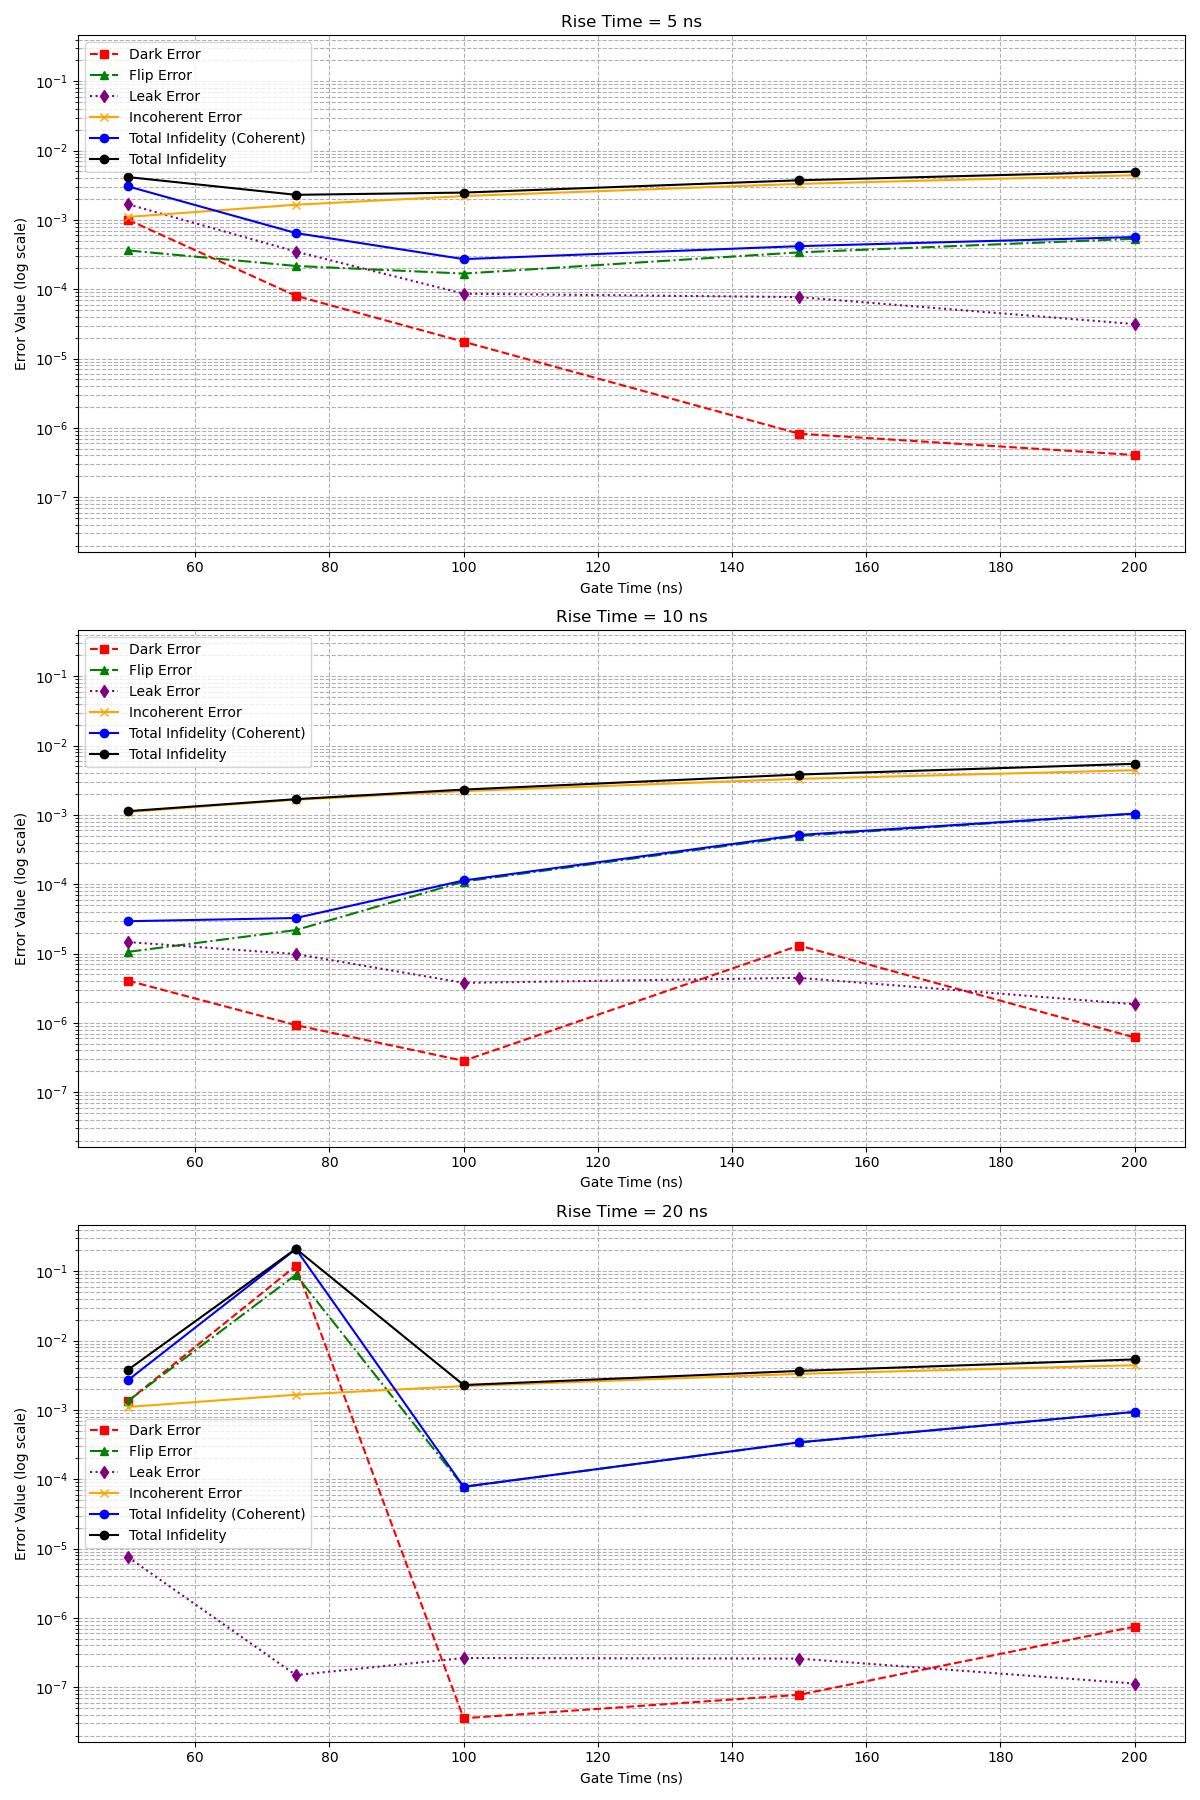


Summary for t_r = 5 ns (Second Set):
  t_g = 50 ns: optalpha = 960.430426+0.000000j, dark = 1.004e-03, flip = 3.631e-04, leak = 1.679e-03, delta_F_incoherent = 0.001105, total_infidelity = 0.004151
  t_g = 75 ns: optalpha = 520.466426+0.000000j, dark = 8.046e-05, flip = 2.170e-04, leak = 3.496e-04, delta_F_incoherent = 0.001657, total_infidelity = 0.002304
  t_g = 100 ns: optalpha = 367.054257+0.000000j, dark = 1.750e-05, flip = 1.684e-04, leak = 8.628e-05, delta_F_incoherent = 0.002210, total_infidelity = 0.002482
  t_g = 150 ns: optalpha = 234.096114+0.000000j, dark = 8.248e-07, flip = 3.408e-04, leak = 7.708e-05, delta_F_incoherent = 0.003315, total_infidelity = 0.003734
  t_g = 200 ns: optalpha = 172.309685+0.000000j, dark = 4.063e-07, flip = 5.349e-04, leak = 3.147e-05, delta_F_incoherent = 0.004420, total_infidelity = 0.004987

Summary for t_r = 10 ns (Second Set):
  t_g = 50 ns: optalpha = 1162.642096+0.000000j, dark = 4.061e-06, flip = 1.058e-05, leak = 1.465e-05, delta_F_inco

In [354]:
import numpy as np
import matplotlib.pyplot as plt

# Define the t_r values used in the simulation
t_r_values = [5, 10, 20]  # Updated to include 15 ns

# Plotting with three subplots for the second set
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharey=True)

for ax, t_r in zip([ax1, ax2, ax3], t_r_values):
    # Plot dark error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['dark'], 
                label='Dark Error', marker='s', linestyle='--', color='red')
    
    # Plot flip error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['flip'], 
                label='Flip Error', marker='^', linestyle='-.', color='green')
    
    # Plot leak error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['leak'], 
                label='Leak Error', marker='d', linestyle=':', color='purple')
    
    # Plot incoherent fidelity error
    ax.semilogy(results[t_r]['t_g'], results[t_r]['delta_F_incoherent'], 
                label='Incoherent Error', marker='x', linestyle='-', color='orange')
    
    # Calculate and plot total infidelity (coherent)
    total_infidelity_coherent = [d + f + l for d, f, l in zip(results[t_r]['dark'], results[t_r]['flip'], 
                                                            results[t_r]['leak'])]
    ax.semilogy(results[t_r]['t_g'], total_infidelity_coherent, 
                label='Total Infidelity (Coherent)', marker='o', linestyle='-', color='blue')

    # Calculate and plot total infidelity
    total_infidelity = [d + f + l + i for d, f, l, i in zip(results[t_r]['dark'], results[t_r]['flip'], 
                                                            results[t_r]['leak'], results[t_r]['delta_F_incoherent'])]
    ax.semilogy(results[t_r]['t_g'], total_infidelity, 
                label='Total Infidelity', marker='o', linestyle='-', color='black')
    
    ax.set_xlabel('Gate Time (ns)')
    ax.set_ylabel('Error Value (log scale)')
    ax.set_title(f'Rise Time = {t_r} ns')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results for all iterations (optional summary for second set)
for t_r in t_r_values:
    print(f"\nSummary for t_r = {t_r} ns (Second Set):")
    for i, t_g in enumerate(t_g_values):
        total_infidelity = (results[t_r]['dark'][i] + results[t_r]['flip'][i] + 
                           results[t_r]['leak'][i] + results[t_r]['delta_F_incoherent'][i])
        print(f"  t_g = {t_g} ns: "
              f"optalpha = {results[t_r]['optalpha'][i]:.6f}, "
              f"dark = {results[t_r]['dark'][i]:.3e}, "
              f"flip = {results[t_r]['flip'][i]:.3e}, "
              f"leak = {results[t_r]['leak'][i]:.3e}, "
              f"delta_F_incoherent = {results[t_r]['delta_F_incoherent'][i]:.6f}, "
              f"total_infidelity = {total_infidelity:.6f}")

## Pulse shapes and continuous Rabi

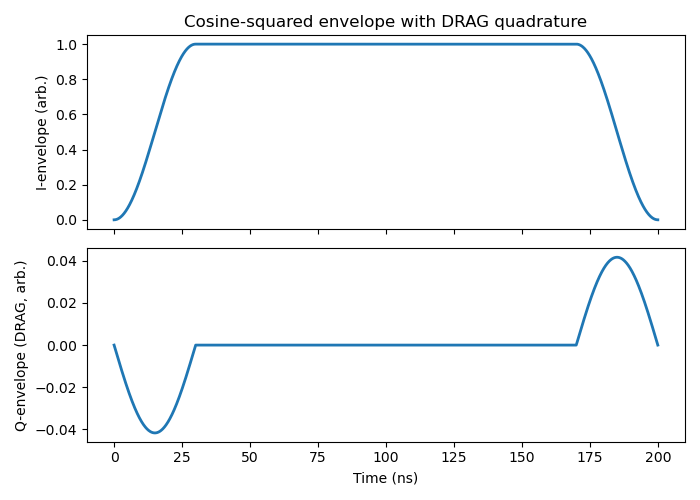

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# Base cosine-squared rise/flat/fall envelope (vectorized)
def envelope_function(t, tg, t_r):
    t = np.asarray(t)
    f = np.zeros_like(t, dtype=float)

    rise = (t < t_r)
    flat = (t >= t_r) & (t <= tg - t_r)
    fall = (t > tg - t_r) & (t <= tg)

    f[rise] = np.sin(np.pi * t[rise] / (2 * t_r))**2
    f[flat] = 1.0
    f[fall] = np.sin(np.pi * (tg - t[fall]) / (2 * t_r))**2
    return f

# Exact analytic derivative of the envelope
def envelope_derivative(t, tg, t_r):
    t = np.asarray(t)
    df = np.zeros_like(t, dtype=float)

    rise = (t < t_r)
    fall = (t > tg - t_r) & (t <= tg)

    # d/dt [sin^2(pi t / (2 t_r))] = (pi/(2 t_r)) * sin(pi t / t_r)
    df[rise] = (np.pi / (2 * t_r)) * np.sin(np.pi * t[rise] / t_r)
    # d/dt [sin^2(pi (tg - t) / (2 t_r))] = -(pi/(2 t_r)) * sin(pi (tg - t) / t_r)
    df[fall] = -(np.pi / (2 * t_r)) * np.sin(np.pi * (tg - t[fall]) / t_r)
    return df

# DRAG: I(t) = envelope, Q(t) = beta * dI/dt   (use beta = -1/delta for standard DRAG)
def drag_components(t, tg, t_r, beta):
    I = envelope_function(t, tg, t_r)
    dIdt = envelope_derivative(t, tg, t_r)
    Q = beta * dIdt
    return I, Q

# ---- demo / plotting ----
tg   = 200e-9      # total gate length [s]
t_r  = 30e-9       # rise/fall time [s]
delta = 2*np.pi*200e6  # example anharmonicity = 200 MHz (rad/s)
beta  = -1.0/delta     # textbook DRAG coefficient (tune as needed)

t = np.linspace(0.0, tg, 2000)
I, Q = drag_components(t, tg, t_r, beta=beta)

fig, ax = plt.subplots(2, 1, figsize=(7,5), sharex=True)
ax[0].plot(t*1e9, I, lw=2)
ax[0].set_ylabel("I-envelope (arb.)")
ax[0].set_title("Cosine-squared envelope with DRAG quadrature")

ax[1].plot(t*1e9, Q, lw=2)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Q-envelope (DRAG, arb.)")
plt.tight_layout()
plt.show()


In [242]:
import numpy as np

def envelop_function_drag_coeff(t, tg, t_r, beta):
    """
    Returns a SINGLE complex LO coefficient for DRAG at time t.
      coeff(t) = I(t) + 1j * beta * dI/dt
    Use beta ≈ -1/Δ (Δ = anharmonicity in rad/s) as a starting point.
    """
    if t < 0 or t > tg:
        I = 0.0
        dIdt = 0.0
    elif t < t_r:
        I = np.sin(np.pi * t / 2 / t_r) ** 2
        dIdt = (np.pi / (2 * t_r)) * np.sin(np.pi * t / t_r)
    elif t <= tg - t_r:
        I = 1.0
        dIdt = 0.0
    else:  # fall
        I = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
        dIdt = -(np.pi / (2 * t_r)) * np.sin(np.pi * (tg - t) / t_r)

    return I + 1j * beta * dIdt


nF =  (0.0062833398591831255+1.8680182759576486e-15j)
nT =  (-1.1388137597044103+5.0852216112105017e-17j)
eta =  -0.061516763067987784


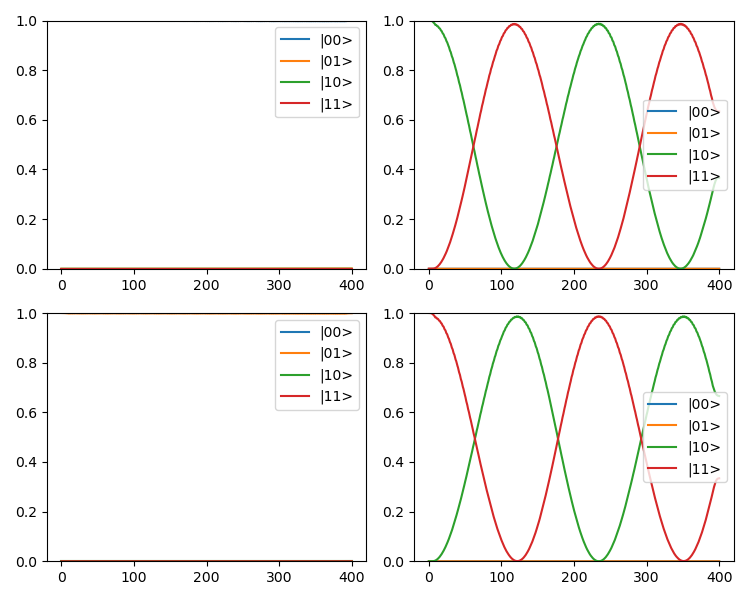

In [375]:
#trying to get the time evolution with different envelopes

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])
    # return 2 *3.14* np.cos(w_d*t) * envelop_function_drag_coeff(t, args['t_g'], args['t_r'], beta=args['beta'])



EFT  = .011/95.5
EF   = .12/65
ET   = .163 / 95.5
beta = 0#-1/(2*np.pi*200e6)  #200MHz anharmonicity
nF   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print('nF = ', nF)
print('nT = ', nT)

t_r = 10
t_g = 400
t_list = np.linspace(0, t_g, 1000)
alpha =38*2.5
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r, 'beta': beta}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF, nT))
print('eta = ', eta)

H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(0, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

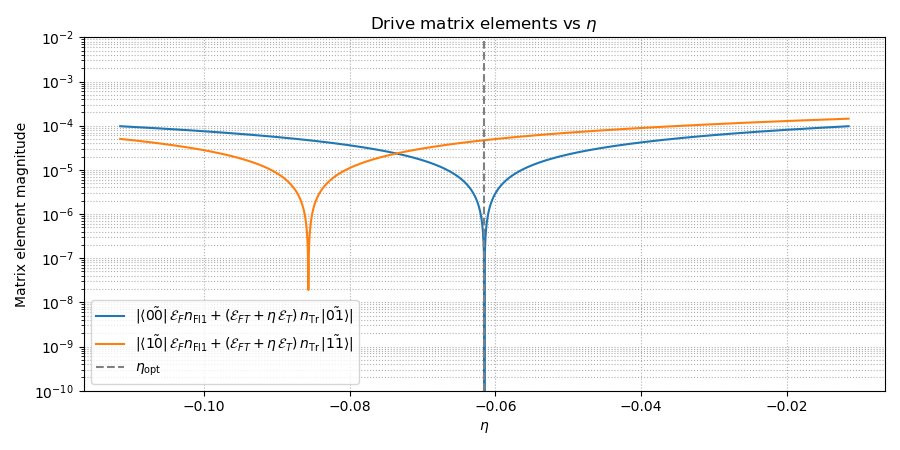

In [282]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(eta - .05, eta + .05, 4001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(eta, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.ylim(1e-10, 1e-2)
plt.show()


## Checking incoherent error


In [117]:
import qutip as qt
import scqubits as scq
import numpy as np

# Note: The following variables need to be defined before running this code:
# - Fl1: scq.Fluxonium(...) or similar
# - Tr: scq.Transmon(...) or similar
# - H_full: the full Hamiltonian (e.g., from scq.HilbertSpace)
# - n_Fl1_full: the number operator for Fl1 lifted to full space (with op_in_eigenbasis=False for bare drive)
# - n_Tr_full: the number operator for Tr lifted to full space (with op_in_eigenbasis=False)
# - dressed_epairs: 2x2 array of [energy, state] for dressed |00>, |01>, |10>, |11>
# - g1_F_01, gphi_F_01, g1_F_12, gphi_F_12: decoherence rates for Fluxonium 0-1 and 1-2 transitions
# - g1_T_01, gphi_T_01, g1_T_12, gphi_T_12: decoherence rates for Transmon 0-1 and 1-2 transitions
# - time_dep: time-dependent function for the pulse (defined below as an example)

# Example definition for time_dep (adjust as needed)
def time_dep(t, args):
    w_d = args['w_d']
    t_g = args['t_g']
    t_r = args['t_r']
    if t <= 0 or t >= t_g:
        return 0.0
    if t < t_r:
        envelope = np.sin(np.pi * t / (2 * t_r))**2
    elif t > t_g - t_r:
        envelope = np.sin(np.pi * (t_g - t) / (2 * t_r))**2
    else:
        envelope = 1.0
    return envelope * np.cos(w_d * t)

# Ideal CNOT gate in computational basis (assuming Fl1 control, Tr target)
idcomp = qt.Qobj(cnot().full())

# Projector to computational subspace in full Hilbert space
comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1],
              dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
P = sum([state * state.dag() for state in comp_space])

# Define U_full2comp to project operator to 4x4 computational matrix
def U_full2comp(U_full):
    U_mat = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            U_mat[i, j] = comp_space[i].dag() * U_full * comp_space[j]
    return qt.Qobj(U_mat)

# --- Define Collapse Operators ---
trunc = 6  # Set truncation size (change based on your qubit model)
P00 = lambda dim: qt.basis(dim,0) * qt.basis(dim,0).dag()
P11 = lambda dim: qt.basis(dim,1) * qt.basis(dim,1).dag()
P22 = lambda dim: qt.basis(dim,2) * qt.basis(dim,2).dag()
P01 = lambda dim: qt.basis(dim,0) * qt.basis(dim,1).dag()   # |0><1|
P12 = lambda dim: qt.basis(dim,1) * qt.basis(dim,2).dag()   # |1><2|

# --- Lift projectors to full Hilbert space: act on Fl1 or Tr, identity on the other qubit ---
L_F_01_relax = scq.identity_wrap(P01(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)
L_F_01_phi   = scq.identity_wrap(P00(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)
L_F_12_relax = scq.identity_wrap(P12(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)
L_F_12_phi   = scq.identity_wrap(P22(trunc), Fl1, [Fl1, Tr], op_in_eigenbasis=True)

L_T_01_relax = scq.identity_wrap(P01(trunc), Tr, [Fl1, Tr], op_in_eigenbasis=True)
L_T_01_phi   = scq.identity_wrap(P00(trunc), Tr, [Fl1, Tr], op_in_eigenbasis=True)
L_T_12_relax = scq.identity_wrap(P12(trunc), Tr, [Fl1, Tr], op_in_eigenbasis=True)
L_T_12_phi   = scq.identity_wrap(P22(trunc), Tr, [Fl1, Tr], op_in_eigenbasis=True)

# Collapse operators for both qubits (relaxation and dephasing)
c_ops = [
    np.sqrt(g1_F_01) * L_F_01_relax,
    np.sqrt(2*gphi_F_01) * L_F_01_phi,
    np.sqrt(g1_F_12) * L_F_12_relax,
    np.sqrt(2*gphi_F_12) * L_F_12_phi,
    np.sqrt(g1_T_01) * L_T_01_relax,
    np.sqrt(2*gphi_T_01) * L_T_01_phi,
    np.sqrt(g1_T_12) * L_T_12_relax,
    np.sqrt(2*gphi_T_12) * L_T_12_phi,
]

def gate(H_tot, args, c_ops):
    """
    This function evolves the system under both unitary (coherent) and noisy (incoherent) dynamics.
    """
    # Define the computational space (dressed states)
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1],
                  dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]

    # Evolve the system with mesolve using the collapse operators (c_ops)
    U_t = evolution_subspace(H_tot, args, comp_space, t_list, c_ops)
    
    # Return the evolved state (after mesolve), which includes both coherent and incoherent contributions
    return U_t[-1]

def evolution_psi_microwave(H_tot, psi0, t_points, args, c_ops):
    """
    Evolve the system under both coherent and incoherent dynamics using mesolve,
    and project into the computational subspace.
    """
    result = qt.mesolve(H_tot, psi0, t_points, c_ops=c_ops, args=args, options=qt.Options(nsteps=100000))
    
    # Project each evolved state into the computational subspace (dimension 4 for 2 qubits)
    computational_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    
    # Project final states to computational subspace
    projected_states = []
    for state in result.states:
        projected_state = sum(state.overlap(comp_state) * comp_state for comp_state in computational_space)
        projected_states.append(projected_state)

    return projected_states

def evolution_subspace(H_tot, args, subspace_states, t_points, c_ops):
    """
    Evolve the system in the computational subspace with decoherence using mesolve,
    and project the results to the computational subspace.
    """
    psi_t = []
    for psi_0 in subspace_states:
        # Evolve each state using mesolve with collapse operators (c_ops)
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args, c_ops=c_ops)
        psi_t.append(temp)

    # Initialize the 4x4 superoperator (unitary evolution in computational space)
    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0 * subspace_states[0] * subspace_states[0].dag()  # Initialize as Qobj
    for ind, psi_0 in enumerate(subspace_states):
        # Compute the final state as the outer product of the evolved state
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

# --- Helper Function: Build Superoperator (16x16) ---
def build_superop(H_tot, args, c_ops, t_list, comp_kets, P):
    """
    Build the superoperator (Choi matrix) for the noisy two-qubit gate.
    """
    # Operator basis: each matrix element of the computational space
    E = [comp_kets[m] * comp_kets[n].dag() for m in range(4) for n in range(4)]
    
    cols = []
    for Emn in E:
        # Evolve each operator (density matrix) under the noise (c_ops)
        sol = qt.mesolve(H_tot, Emn, t_list, c_ops=c_ops, args=args, options=qt.Options(nsteps=100000))
        Emn_tg = sol.states[-1]  # Final evolved state (36x36 Qobj)
        
        # Project back to computational subspace
        Emn_proj = P * Emn_tg * P
        
        # Extract matrix elements in the computational basis
        M4 = np.zeros((4, 4), dtype=complex)
        for i, ei in enumerate(comp_kets):
            for j, ej in enumerate(comp_kets):
                M4[i, j] = Emn_proj.matrix_element(ei.dag(), ej)  # <ei|Emn_proj|ej>
        
        # Flatten the matrix to a column (16x1 vector)
        cols.append(M4.reshape(16, order='F'))  # Fortran vec (column-major)
    
    # Assemble the full 16x16 superoperator (Choi matrix)
    S = np.column_stack(cols)  # 16x16 matrix representing the quantum channel
    return S

# --- Helper Function: Fidelity Calculation ---
def super_from_unitary(U4):
    """
    Convert a unitary matrix (U) to the corresponding superoperator (16x16 Choi matrix).
    """
    return np.kron(U4, U4.conj())  # Kronecker product of U and its conjugate

def avg_gate_fidelity_from_super(S_real, U_ideal_qobj):
    """
    Compute the average gate fidelity from the superoperator.
    """
    d = 4
    U_ideal_mat = U_ideal_qobj.full()
    S_ideal = super_from_unitary(U_ideal_mat)  # Ideal superoperator (16x16)
    F_e = np.trace(S_ideal.conj().T @ S_real).real / (d * d)  # Fidelity between real and ideal
    Favg = (d * F_e + 1) / (d + 1)  # Total fidelity
    return Favg

def abs_fidelity_CX1_with_crosstalk(params, t_g, t_r, EF, EFT, ET, c_ops):
    """
    Compute the total fidelity (coherent + incoherent) for the two-qubit gate.
    """
    alpha, eta_p, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0]) * detuning
    H_drive = alpha * (EF * n_Fl1_full + (EFT + ET * eta_p) * n_Tr_full)
    H_tot = [H_full, [H_drive, time_dep]]
    args = {'t_g': t_g, 'w_d': w_d, 't_r': t_r}

    # Define computational basis states in full space
    comp_kets = comp_space  # Use the dressed states

    # Compute coherent fidelity (without decoherence)
    U_full_coherent = gate(H_tot, args, c_ops=[])  # No c_ops for coherent
    U_act_coherent = U_full2comp(U_full_coherent)
    op1 = U_act_coherent.dag() * U_act_coherent
    op2 = idcomp.dag() * U_act_coherent
    F_coherent = (op1.tr() + (abs(op2.tr()))**2) / 20.0

    # Compute full noisy superoperator
    S_real = build_superop(H_tot, args, c_ops, t_list, comp_kets, P)  # Real superoperator (16x16)
    F_total = avg_gate_fidelity_from_super(S_real, idcomp)  # Full fidelity including noise

    # Note: Originally F_total = F_coherent + F_incoherent, but this doesn't make sense.
    # Instead, return the full fidelity. If you want to optimize, consider using -F_total.
    # If incoherent contribution is desired separately, compute F_incoherent ≈ F_total - F_coherent (approximation for small errors)
    return F_total  # Changed to positive for direct fidelity; adjust if optimizing

# --- Define Initial Parameters ---
t_g = 100  # Gate time (ns)
t_r = 10   # Rise time (ns)
EF = 0.05  # Drive amplitude for Fluxonium
EFT = 0.05  # Crosstalk drive amplitude
ET = 0.05  # Transmon drive amplitude
alpha = 1.0  # Scaling factor for drive amplitude
eta_p = 0.0  # Crosstalk parameter
detuning = 1.0  # Detuning factor
t_list = np.linspace(0, t_g, 30)

# --- Run the Fidelity Calculation ---
# Calculate total fidelity for given parameters (no optimization)
result_fidelity = abs_fidelity_CX1_with_crosstalk(
    [alpha, eta_p, detuning], t_g, t_r, EF, EFT, ET, c_ops
)

# Output the result
print(f"Total Fidelity: {result_fidelity}")

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 